#### python kernel : 3.9.7

######### Neural Prophet_train 과 다른 점 : 데이터 5100값이하들을 선형보간법으로 대체, 날짜 다시 맵핑하여 비어 있는 값들도 선형 보간법으로 대체     
AR net option 사용

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from neuralprophet import NeuralProphet

#### 학습용 데이터 서버 업로드 (stfp를 이용)  
1.  (linux server) mkdir "폴더명"   
2.  (Window local) cmd 창 : 파일 디렉터리로 이동 -> sftp [ID]@[서버주소] -> pw 입력 -> 리눅스 서버 디렉터리 이동 -> put(window local 파일명) 

학습데이터 불러오기


In [2]:
#data 불러오기
data=pd.read_excel('/home/ykkim/Train_data/무림페이퍼_15분사용전력_210401-220630.xlsx')   #pip install openpyxl 

In [3]:
data=data.drop(['등록시각'],axis=1)

data['기준시각']=pd.to_datetime(data['기준시각'])
print(data.info(),data.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42766 entries, 0 to 42765
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   기준시각         42766 non-null  datetime64[ns]
 1   직전 15분 사용전력  42766 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 668.3 KB
None 기준시각           0
직전 15분 사용전력    0
dtype: int64


#날짜별 결측치 확인

In [4]:
#daterange
dates = pd.date_range('2021-04-01 00:00:00', periods=43776, freq='15min')
dates = pd.DataFrame(dates,columns=['기준시각'])

#leftjoin
datas=pd.merge(dates,data,how='left',on='기준시각')

print(datas.isna().sum(), datas['직전 15분 사용전력'].min(),datas['직전 15분 사용전력'].max(),datas['직전 15분 사용전력'].median())

datas
datas.info()

기준시각              0
직전 15분 사용전력    1010
dtype: int64 571.2 8820.0 7341.6
<class 'pandas.core.frame.DataFrame'>
Int64Index: 43776 entries, 0 to 43775
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   기준시각         43776 non-null  datetime64[ns]
 1   직전 15분 사용전력  42766 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.0 MB


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


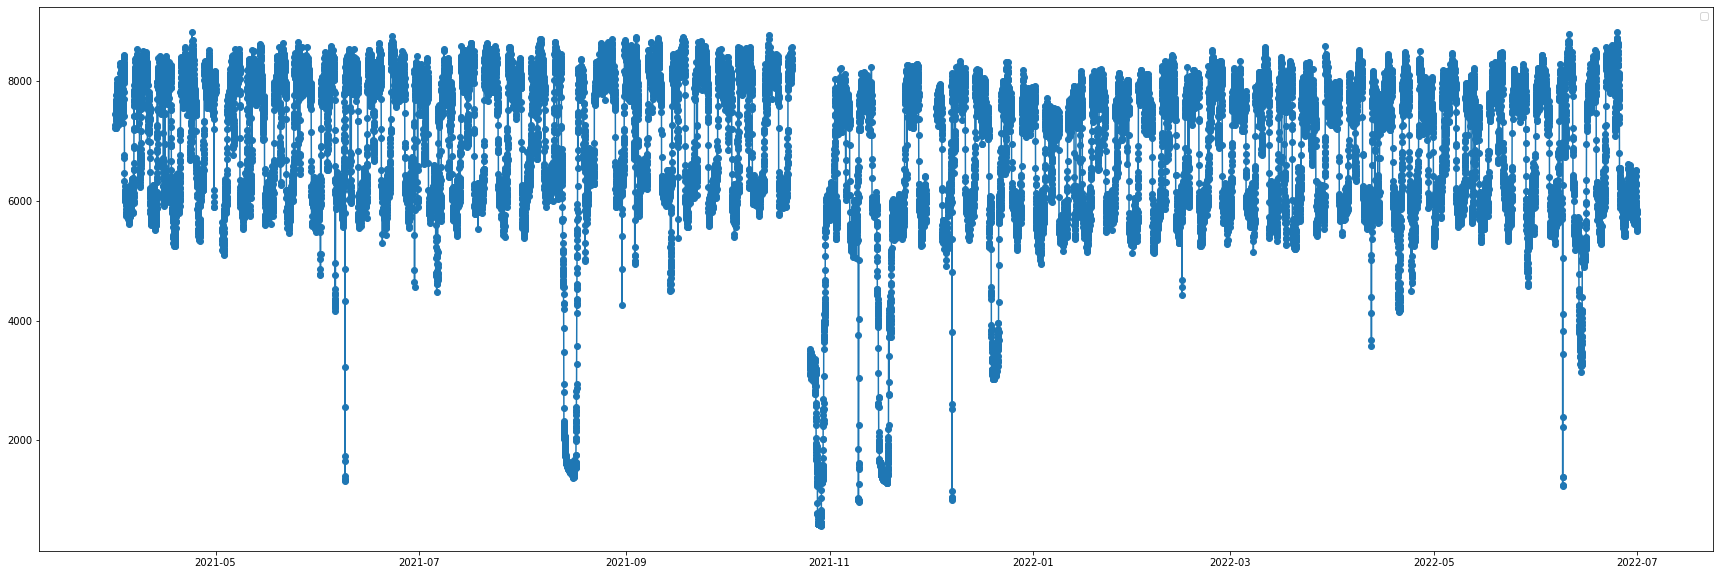

In [5]:
# 기존 데이터 그래프(결측 처리 전)
import matplotlib.pyplot as plt

plt.figure(figsize=(30,10))
kws = dict(marker='o')
plt.plot(datas['기준시각'],datas['직전 15분 사용전력'], **kws)   
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


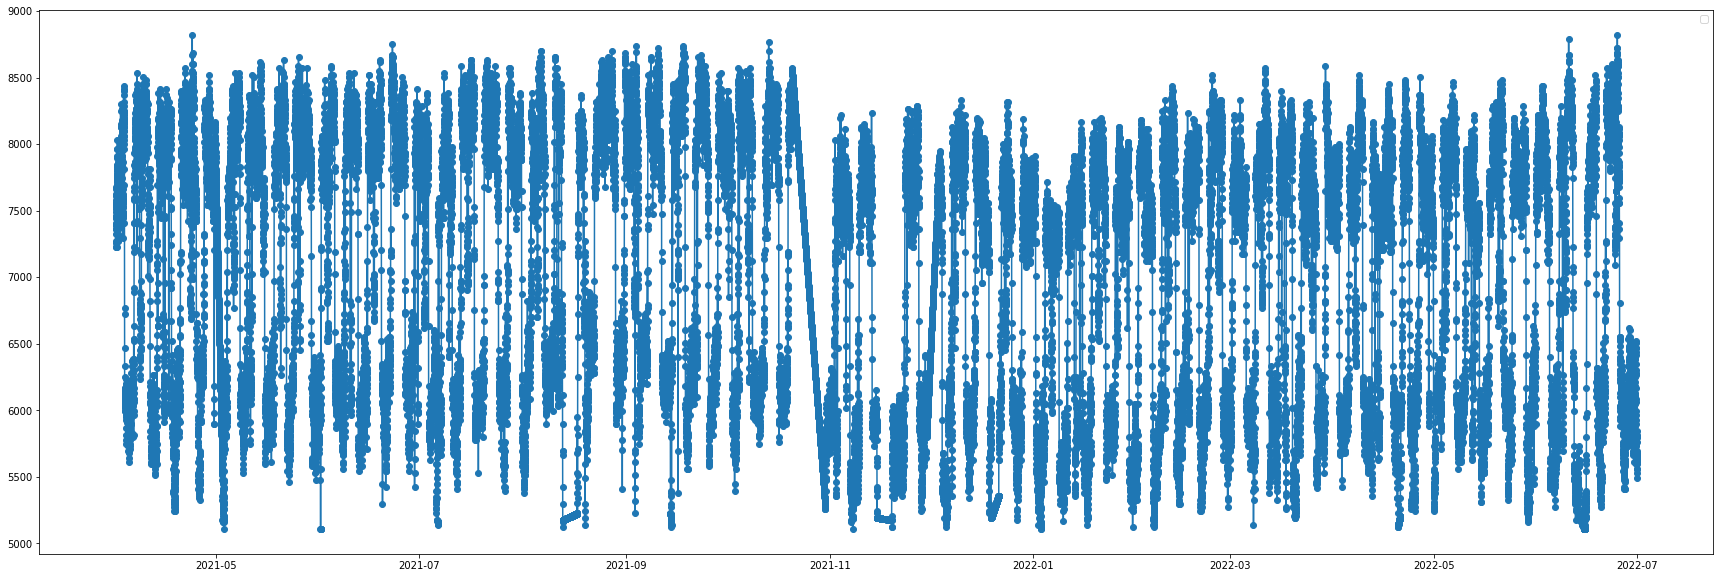

In [6]:
# 5100 이하값들은 이전 값들로 대체
import numpy as np
datas.loc[(datas['직전 15분 사용전력'] <= 5100),'직전 15분 사용전력']= np.nan
datas.isna().sum()

# 선형 보간(linear) : 이상치,5100이하 na값 후
from scipy import interpolate
datas['직전 15분 사용전력']=datas['직전 15분 사용전력'].interpolate()

#보간후
plt.figure(figsize=(30,10))
kws = dict(marker='o')
plt.plot(datas['기준시각'],datas['직전 15분 사용전력'], **kws)   
plt.legend()
plt.show()


In [7]:
import sys
sys.path.append('/home/ykkim/Baseline_Analysis/4. Supervised_model/' )  #모듈 저장 위치 지정 
print(sys.path)

['/home/ykkim/Time_Series_models/FEMS_predict/Neural_Prophet', '/home/ykkim/anaconda3/envs/NeuralProphet/lib/python39.zip', '/home/ykkim/anaconda3/envs/NeuralProphet/lib/python3.9', '/home/ykkim/anaconda3/envs/NeuralProphet/lib/python3.9/lib-dynload', '', '/home/ykkim/anaconda3/envs/NeuralProphet/lib/python3.9/site-packages', '/home/ykkim/Baseline_Analysis/4. Supervised_model/']


In [11]:
import neural_prophet_module as NP

In [8]:
#lag, diff feature 생성
# for i in range(1,97):
#     NP.gen_feature_lag(datas,'직전 15분 사용전력','l_'+str(i),i)
    


In [9]:
print(datas.shape,datas.isna().sum())

(43776, 2) 기준시각           0
직전 15분 사용전력    0
dtype: int64


In [ ]:
# #na값 삭제
# datas=datas.dropna()
# datas



In [12]:
# train_test split
df_train,df_test=NP.train_test_split(datas,Time_name='기준시각',train_cut_date='2022-06-30',val_cut_date='2022-06-30',end_time='2022-06-30 23:45:00',want_val='N')  #validation set은 추후에 분리

train_df= 2021-04-01 00:00:00 ~ 2022-06-29 23:45:00 , 43680
test_df= 2022-06-30 00:00:00 ~ 2022-06-30 23:45:00 , 96


In [14]:
df_train

,기준시각,직전 15분 사용전력
0,2021-04-01 00:00:00,7224.0
1,2021-04-01 00:15:00,7274.4
2,2021-04-01 00:30:00,7442.4
3,2021-04-01 00:45:00,7392.0
4,2021-04-01 01:00:00,7576.8
...,...,...
43675,2022-06-29 22:45:00,5678.4
43676,2022-06-29 23:00:00,5611.2
43677,2022-06-29 23:15:00,5896.8
43678,2022-06-29 23:30:00,5930.4


In [15]:
# neural prophet을 돌리기 위해서는 Time변수 : 'ds', Y변수 : 'y' column명 변경이 필요함.
df_train.rename(columns={'기준시각': "ds", '직전 15분 사용전력': "y"}, inplace=True)
df_test.rename(columns={'기준시각': "ds", '직전 15분 사용전력': "y"}, inplace=True)

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_7265/1507035403.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.rename(columns={'기준시각': "ds", '직전 15분 사용전력': "y"}, inplace=True)

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_7265/1507035403.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.rename(columns={'기준시각': "ds", '직전 15분 사용전력': "y"}, inplace=True)



In [19]:
#model 
model=NeuralProphet(
        #trend
        n_changepoints=1000,  # 데이터의 트렌드가 변화하는 포인트 수를 지정
        changepoints_range=0.95,
        #seasonality
        seasonality_mode="multiplicative",
        #using AR-net
        n_forecasts=96,
        n_lags=96,
        # num_hidden_layers=2,
        learning_rate=1.0,
        d_hidden=8,
        impute_missing= "True", # 결측치 보정
        normalize="auto"
       )

In [20]:
# train,val 분리
train,val=model.split_df(df_train, valid_p =0.2)

INFO - (NP.df_utils._infer_frequency) - Major frequency 15T corresponds to 99.998% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as 15T


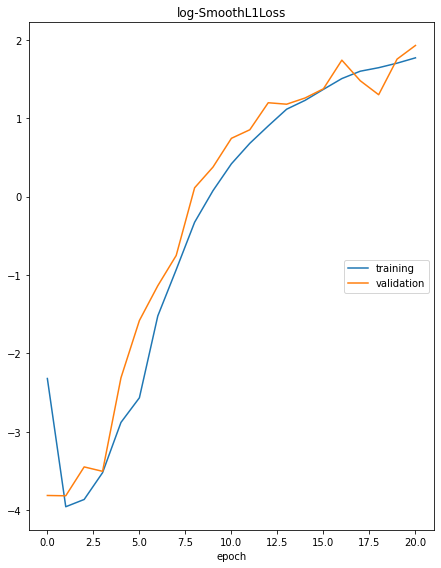

log-SmoothL1Loss
	training         	 (min:   -3.955, max:    1.769, cur:    1.769)
	validation       	 (min:   -3.815, max:    1.927, cur:    1.927)


In [21]:
metrics=model.fit(train,validation_df=val,progress='plot') 

print("SmoothL1Loss: ", metrics.SmoothL1Loss.tail(1).item())
print("MAE(Train): ", metrics.MAE.tail(1).item())
print("MAE(val): ", metrics.MAE_val.tail(1).item())

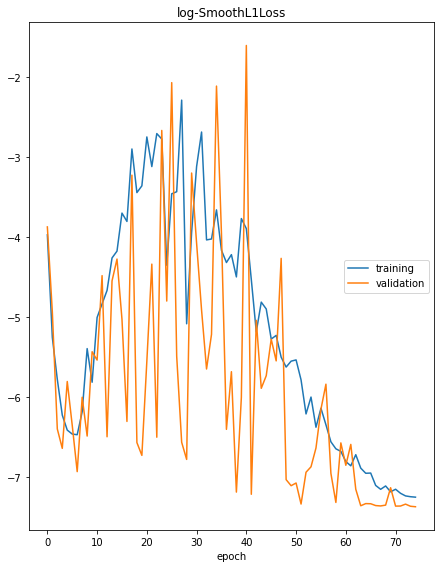

log-SmoothL1Loss
	training         	 (min:   -7.247, max:   -2.285, cur:   -7.247)
	validation       	 (min:   -7.366, max:   -1.603, cur:   -7.366)
SmoothL1Loss:  0.0007125521871857786
MAE(Train):  85.0779814725077
MAE(val):  84.25474893920955


In [19]:
#모델 학습
# model, metrics= NP.NP_model(df_train,df_test,Time_name='기준시각',Y_name='직전 15분 사용전력',num_futureregressor=96,val_p=0.2)   # pip install livelossplot

INFO - (NP.df_utils._infer_frequency) - Major frequency 15T corresponds to 99.998% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 15T
WARNING - (py.warnings._showwarnmsg) - /home/ykkim/anaconda3/envs/NeuralProphet/lib/python3.9/site-packages/neuralprophet/forecaster.py:2060: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(future_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency 15T corresponds to 99.998% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 15T
INFO - (NP.df_utils._infer_frequency) - Major frequency 15T corresponds to 99.998% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 15T
WARNING - (py.warnings._showwarnmsg) - /home/ykkim/anaconda3/envs/NeuralProphet/lib/python3.9/site-packages/neuralprophet/forecaster

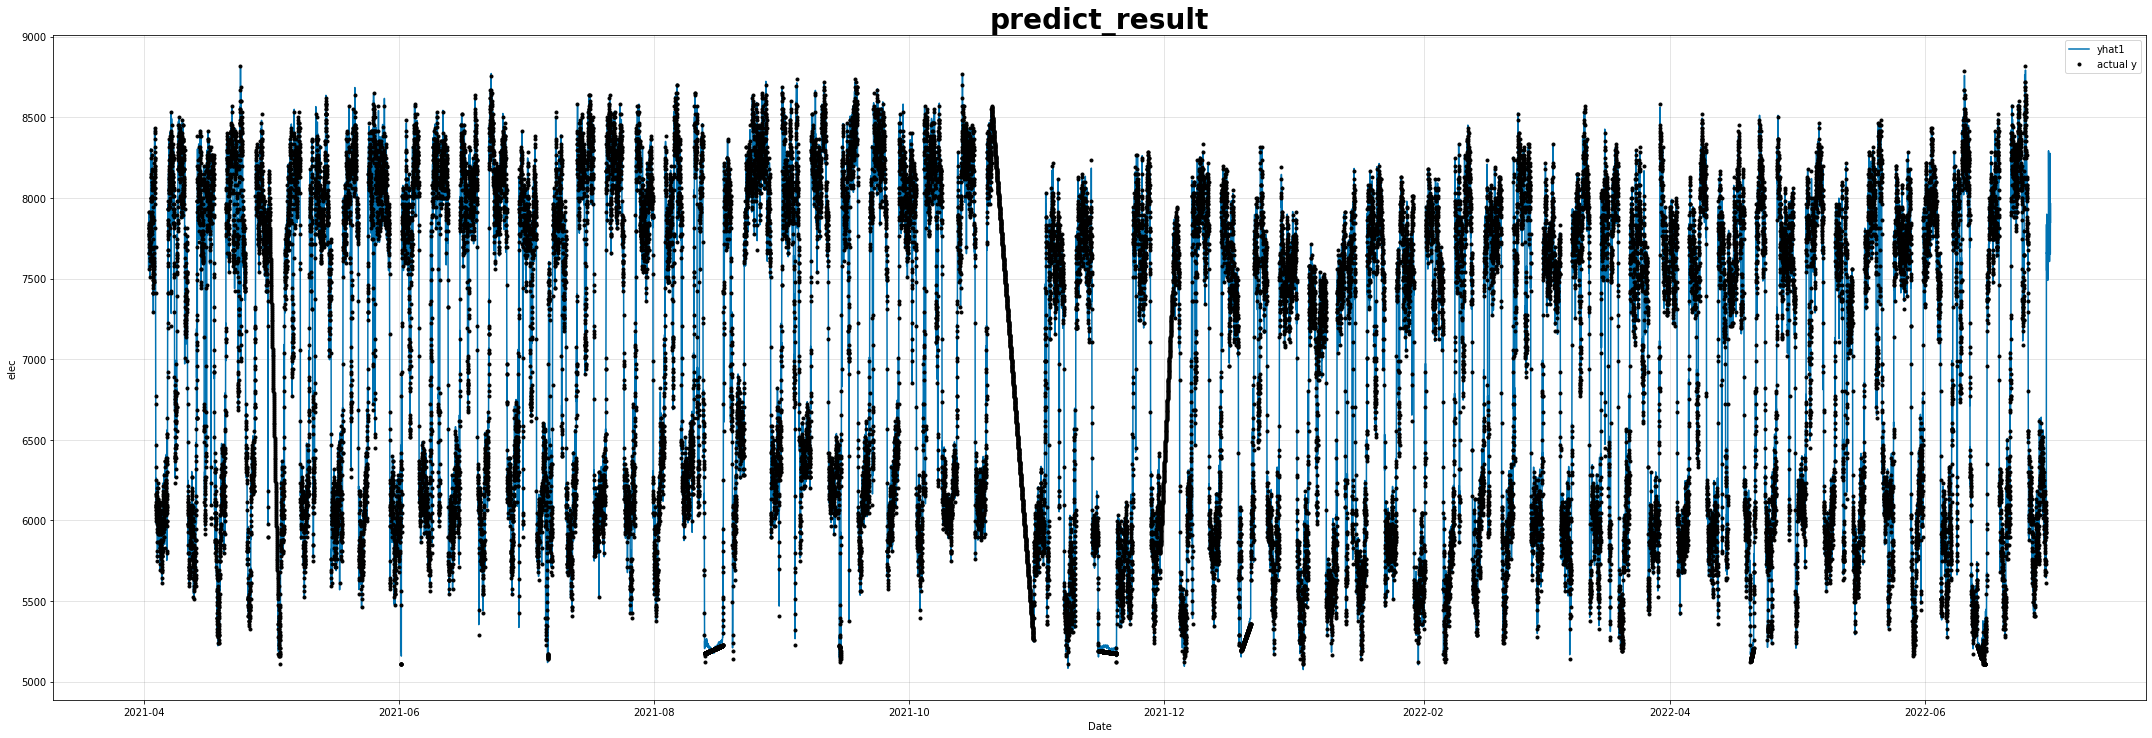

In [20]:
#train 후 예측
forecast=NP.NP_model_predict(df_train,model,num_futureregressor=96,predict_period=96) #하루치 예측

In [21]:
forecast.tail(96)

,ds,y,yhat1,residual1,trend,season_weekly,season_daily,future_regressors_additive,future_regressor_l_1,future_regressor_l_10,...,future_regressor_l_88,future_regressor_l_89,future_regressor_l_9,future_regressor_l_90,future_regressor_l_91,future_regressor_l_92,future_regressor_l_93,future_regressor_l_94,future_regressor_l_95,future_regressor_l_96
43584,2022-06-30 00:00:00,NaN,7560.916016,NaN,5137.695801,0.124957,0.158764,2414.568359,2695.572998,-24.883743,...,26.813967,-46.622253,-36.938751,19.329588,-0.700449,14.171154,-37.687000,27.760458,-4.029155,15.471639
43585,2022-06-30 00:15:00,NaN,7659.610352,NaN,5137.695801,0.116749,0.088258,2515.662354,2806.349854,-22.957258,...,24.474493,-45.403374,-35.905499,19.456755,-0.749776,13.689142,-40.735214,27.161310,-4.341493,15.840010
43586,2022-06-30 00:30:00,NaN,7656.448242,NaN,5137.696289,0.108783,0.010057,2515.127930,2806.349854,-22.315098,...,24.114573,-41.442005,-36.680439,18.948082,-0.754709,14.653167,-39.349663,29.358181,-4.247792,17.067919
43587,2022-06-30 00:45:00,NaN,7835.504883,NaN,5137.696777,0.101066,-0.062523,2696.632812,2990.978271,-22.796719,...,25.194330,-40.832561,-33.838997,17.294893,-0.734978,14.749569,-42.120766,28.359606,-4.591363,16.699545
43588,2022-06-30 01:00:00,NaN,7756.079102,NaN,5137.696777,0.093601,-0.117184,2619.101074,2935.589600,-21.030775,...,26.274086,-42.660889,-35.647190,17.040556,-0.670853,14.363958,-42.397877,30.356758,-4.435194,18.050243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43675,2022-06-30 22:45:00,NaN,7658.011719,NaN,5137.727539,0.440942,0.103331,2503.668945,2787.886963,-30.181570,...,28.613560,-49.364742,-45.979706,19.329588,-0.749776,14.074752,-40.180996,28.359606,-4.497662,16.945126
43676,2022-06-30 23:00:00,NaN,7772.072266,NaN,5137.727539,0.450909,0.174664,2615.247314,2898.664062,-28.576168,...,27.713764,-48.450581,-45.721394,20.601271,-0.749776,14.653167,-40.458107,28.958750,-4.435194,17.681871
43677,2022-06-30 23:15:00,NaN,7967.796875,NaN,5137.728027,0.460791,0.219231,2809.309082,3120.218018,-28.415628,...,26.274086,-46.926975,-45.204765,20.219765,-0.799104,14.653167,-42.120766,29.158466,-4.528895,17.436289
43678,2022-06-30 23:30:00,NaN,7866.194336,NaN,5137.728516,0.470577,0.231061,2707.045898,3046.366455,-28.094547,...,27.353844,-44.489212,-44.171513,19.583923,-0.784306,15.617190,-42.120766,30.356758,-4.560129,17.804663


In [23]:
# predict, real 비교 dataframe
result_df=NP.result_df(df_test,forecast)
result_df


,ds,y_x,y_y,yhat1,residual1,trend,season_weekly,season_daily,future_regressors_additive,future_regressor_l_1,...,future_regressor_l_88,future_regressor_l_89,future_regressor_l_9,future_regressor_l_90,future_regressor_l_91,future_regressor_l_92,future_regressor_l_93,future_regressor_l_94,future_regressor_l_95,future_regressor_l_96
0,2022-06-30 00:00:00,5846.4,NaN,7560.916016,NaN,5137.695801,0.124957,0.158764,2414.568359,2695.572998,...,26.813967,-46.622253,-36.938751,19.329588,-0.700449,14.171154,-37.687000,27.760458,-4.029155,15.471639
1,2022-06-30 00:15:00,5812.8,NaN,7659.610352,NaN,5137.695801,0.116749,0.088258,2515.662354,2806.349854,...,24.474493,-45.403374,-35.905499,19.456755,-0.749776,13.689142,-40.735214,27.161310,-4.341493,15.840010
2,2022-06-30 00:30:00,5745.6,NaN,7656.448242,NaN,5137.696289,0.108783,0.010057,2515.127930,2806.349854,...,24.114573,-41.442005,-36.680439,18.948082,-0.754709,14.653167,-39.349663,29.358181,-4.247792,17.067919
3,2022-06-30 00:45:00,5712.0,NaN,7835.504883,NaN,5137.696777,0.101066,-0.062523,2696.632812,2990.978271,...,25.194330,-40.832561,-33.838997,17.294893,-0.734978,14.749569,-42.120766,28.359606,-4.591363,16.699545
4,2022-06-30 01:00:00,5745.6,NaN,7756.079102,NaN,5137.696777,0.093601,-0.117184,2619.101074,2935.589600,...,26.274086,-42.660889,-35.647190,17.040556,-0.670853,14.363958,-42.397877,30.356758,-4.435194,18.050243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2022-06-30 22:45:00,5628.0,NaN,7658.011719,NaN,5137.727539,0.440942,0.103331,2503.668945,2787.886963,...,28.613560,-49.364742,-45.979706,19.329588,-0.749776,14.074752,-40.180996,28.359606,-4.497662,16.945126
92,2022-06-30 23:00:00,5560.8,NaN,7772.072266,NaN,5137.727539,0.450909,0.174664,2615.247314,2898.664062,...,27.713764,-48.450581,-45.721394,20.601271,-0.749776,14.653167,-40.458107,28.958750,-4.435194,17.681871
93,2022-06-30 23:15:00,5493.6,NaN,7967.796875,NaN,5137.728027,0.460791,0.219231,2809.309082,3120.218018,...,26.274086,-46.926975,-45.204765,20.219765,-0.799104,14.653167,-42.120766,29.158466,-4.528895,17.436289
94,2022-06-30 23:30:00,5527.2,NaN,7866.194336,NaN,5137.728516,0.470577,0.231061,2707.045898,3046.366455,...,27.353844,-44.489212,-44.171513,19.583923,-0.784306,15.617190,-42.120766,30.356758,-4.560129,17.804663


In [24]:
dd=result_df.dropna(subset=['yhat1'])
dd

,ds,y_x,y_y,yhat1,residual1,trend,season_weekly,season_daily,future_regressors_additive,future_regressor_l_1,...,future_regressor_l_88,future_regressor_l_89,future_regressor_l_9,future_regressor_l_90,future_regressor_l_91,future_regressor_l_92,future_regressor_l_93,future_regressor_l_94,future_regressor_l_95,future_regressor_l_96
0,2022-06-30 00:00:00,5846.4,NaN,7560.916016,NaN,5137.695801,0.124957,0.158764,2414.568359,2695.572998,...,26.813967,-46.622253,-36.938751,19.329588,-0.700449,14.171154,-37.687000,27.760458,-4.029155,15.471639
1,2022-06-30 00:15:00,5812.8,NaN,7659.610352,NaN,5137.695801,0.116749,0.088258,2515.662354,2806.349854,...,24.474493,-45.403374,-35.905499,19.456755,-0.749776,13.689142,-40.735214,27.161310,-4.341493,15.840010
2,2022-06-30 00:30:00,5745.6,NaN,7656.448242,NaN,5137.696289,0.108783,0.010057,2515.127930,2806.349854,...,24.114573,-41.442005,-36.680439,18.948082,-0.754709,14.653167,-39.349663,29.358181,-4.247792,17.067919
3,2022-06-30 00:45:00,5712.0,NaN,7835.504883,NaN,5137.696777,0.101066,-0.062523,2696.632812,2990.978271,...,25.194330,-40.832561,-33.838997,17.294893,-0.734978,14.749569,-42.120766,28.359606,-4.591363,16.699545
4,2022-06-30 01:00:00,5745.6,NaN,7756.079102,NaN,5137.696777,0.093601,-0.117184,2619.101074,2935.589600,...,26.274086,-42.660889,-35.647190,17.040556,-0.670853,14.363958,-42.397877,30.356758,-4.435194,18.050243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2022-06-30 22:45:00,5628.0,NaN,7658.011719,NaN,5137.727539,0.440942,0.103331,2503.668945,2787.886963,...,28.613560,-49.364742,-45.979706,19.329588,-0.749776,14.074752,-40.180996,28.359606,-4.497662,16.945126
92,2022-06-30 23:00:00,5560.8,NaN,7772.072266,NaN,5137.727539,0.450909,0.174664,2615.247314,2898.664062,...,27.713764,-48.450581,-45.721394,20.601271,-0.749776,14.653167,-40.458107,28.958750,-4.435194,17.681871
93,2022-06-30 23:15:00,5493.6,NaN,7967.796875,NaN,5137.728027,0.460791,0.219231,2809.309082,3120.218018,...,26.274086,-46.926975,-45.204765,20.219765,-0.799104,14.653167,-42.120766,29.158466,-4.528895,17.436289
94,2022-06-30 23:30:00,5527.2,NaN,7866.194336,NaN,5137.728516,0.470577,0.231061,2707.045898,3046.366455,...,27.353844,-44.489212,-44.171513,19.583923,-0.784306,15.617190,-42.120766,30.356758,-4.560129,17.804663


In [25]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(dd['y_x'], dd['yhat1'])

0.32035473315288404

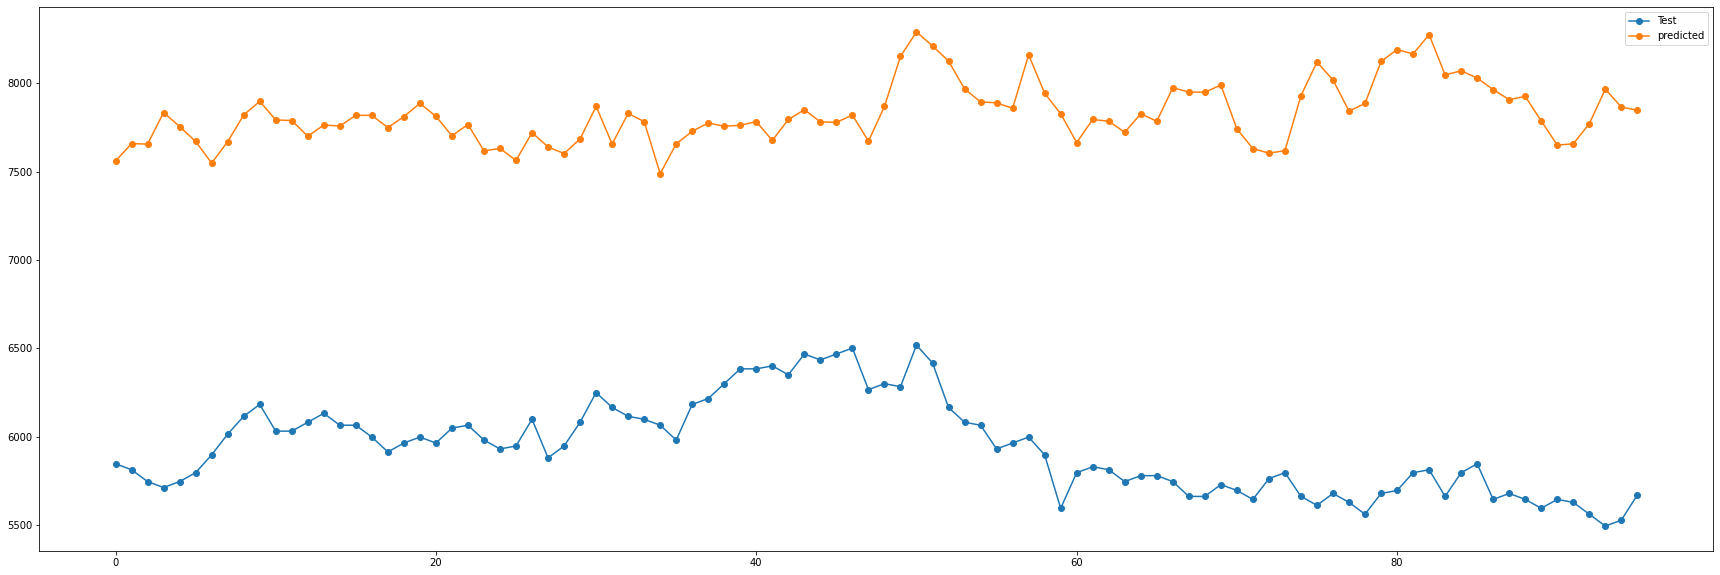

In [26]:
# predict, real 비교 plot
NP.predict_graph(dd['y_x'],dd['yhat1'])

In [18]:
# model save to disk
import pickle

filename = '/home/ykkim/Trained_Model/NeuralProphet_moorim_try2.sav'
pickle.dump(model, open(filename, 'wb'))